<a href="https://colab.research.google.com/github/MagaliDrumare/Cohere-SQL-Agent-/blob/main/sql_agent_cohere_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

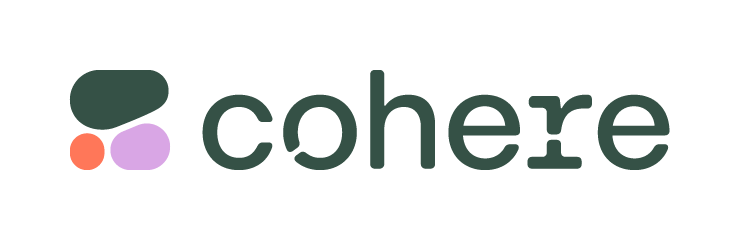

# Notebook Overview

## Motivation
Enterprise customers often store and handle information in relational databases but querying such databases effectively requires bespoke knowledge of the underlying database structure as well as strong SQL coding skills. One way to address these challenges is to build an LLM agent capable of generating and executing SQL queries based on natural language. For example If a user asks: ``what are the top 4 rows in table X``, the agent should be able to generate ``SELECT * FROM X LIMIT 4``, execute this query and return the output to the user.

## Objective
In this notebook we explore how to setup a [Cohere ReAct Agent](https://github.com/langchain-ai/langchain-cohere/blob/main/libs/cohere/langchain_cohere/cohere_agent.py) to answer questions over SQL Databases. We show how this can be done seamlessly with langchain's existing SQLDBToolkit.

## Table of Contents

- [Toolkit Setup](#sec_step0)
- [SQL Agent](#sec_step1)
- [SQL Agent with context](#sec_step2)

<a id="sec_step0"></a>
# Toolkit Setup



In [51]:
pip install langchain langchain_cohere langchain_experimental langchain_community

In [52]:
pip install langchain_community

In [ ]:
 pip install psycopg2

In [53]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere.chat_models import ChatCohere
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
import os

Langchain already has a SQLDBToolkit that consists of 4 tools to handle SQL query generation, execution and validation. To use this, you simply need to define your LLM and DB and pass these into the Toolkit.

These are the following tools:
- 'sql_db_query': executes SQL code on the database
- 'sql_db_schema': returns the schema of tables given the list of tables
- 'sql_db_list_tables': lists the tables in the database
- 'sql_db_query_checker': validates the SQL query




In [ ]:
pip install sqlalchemy

In [60]:
!wget https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip
!unzip chinook.zip

--2024-06-19 15:45:32--  https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip
Resolving www.sqlitetutorial.net (www.sqlitetutorial.net)... 172.67.172.250, 104.21.30.141, 2606:4700:3037::6815:1e8d, ...
Connecting to www.sqlitetutorial.net (www.sqlitetutorial.net)|172.67.172.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305596 (298K) [application/zip]
Saving to: ‘chinook.zip.4’

chinook.zip.4       100%[===================>] 298.43K  --.-KB/s    in 0.01s   

2024-06-19 15:45:32 (21.0 MB/s) - ‘chinook.zip.4’ saved [305596/305596]

Archive:  chinook.zip
replace chinook.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chinook.db              


In [62]:
import sqlite3
conn = sqlite3.connect('chinook.db')

In [63]:
c = conn.cursor()
for row in c.execute('SELECT * FROM albums;'):
    print(row)
conn.close()

(1, 'For Those About To Rock We Salute You', 1)
(2, 'Balls to the Wall', 2)
(3, 'Restless and Wild', 2)
(4, 'Let There Be Rock', 1)
(5, 'Big Ones', 3)
(6, 'Jagged Little Pill', 4)
(7, 'Facelift', 5)
(8, 'Warner 25 Anos', 6)
(9, 'Plays Metallica By Four Cellos', 7)
(10, 'Audioslave', 8)
(11, 'Out Of Exile', 8)
(12, 'BackBeat Soundtrack', 9)
(13, 'The Best Of Billy Cobham', 10)
(14, 'Alcohol Fueled Brewtality Live! [Disc 1]', 11)
(15, 'Alcohol Fueled Brewtality Live! [Disc 2]', 11)
(16, 'Black Sabbath', 12)
(17, 'Black Sabbath Vol. 4 (Remaster)', 12)
(18, 'Body Count', 13)
(19, 'Chemical Wedding', 14)
(20, 'The Best Of Buddy Guy - The Millenium Collection', 15)
(21, 'Prenda Minha', 16)
(22, 'Sozinho Remix Ao Vivo', 16)
(23, 'Minha Historia', 17)
(24, 'Afrociberdelia', 18)
(25, 'Da Lama Ao Caos', 18)
(26, 'Acústico MTV [Live]', 19)
(27, 'Cidade Negra - Hits', 19)
(28, 'Na Pista', 20)
(29, 'Axé Bahia 2001', 21)
(30, 'BBC Sessions [Disc 1] [Live]', 22)
(31, 'Bongo Fury', 23)
(32, 'Carnaval 

In [64]:
# load the cohere api key
import cohere
#co = cohere.Client('ZYL71VHay27tInH8H52ePXdHHV77fmChVoQABYbc')
os.environ["COHERE_API_KEY"] = "XXXXXXXXXXXX"

In [55]:

#from sqlalchemy import create_engine
#import pandas as pd
engine= create_engine('Chinook.sqlite')


In [67]:

DB_NAME='Chinook.db'
MODEL="command-r-plus"

llm = ChatCohere(model=MODEL, temperature=0.1,verbose=True)
db = SQLDatabase.from_uri("sqlite:///chinook.db")


toolkit = SQLDatabaseToolkit(db=db, llm=llm)
context = toolkit.get_context()
tools = toolkit.get_tools()

print('**List of pre-defined Langchain Tools**')
print([tool.name for tool in tools])
print('')
print('**Context to pass to LLM on tables**')
print(context)

**List of pre-defined Langchain Tools**
['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

**Context to pass to LLM on tables**
{'table_info': '\nCREATE TABLE albums (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES artists ("ArtistId")\n)\n\n/*\n3 rows from albums table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE artists (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from artists table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE customers (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40

<a id="sec_step1"></a>
# SQL Agent

we follow the general cohere react agent setup in Langchain to build our SQL agent.

In [68]:

# define the prompt template
prompt = ChatPromptTemplate.from_template("{input}")

# instantiate the ReAct agent
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )



In [69]:
agent_executor.invoke({
   "input": 'what tables are available?',
})



> Entering new AgentExecutor chain...

I will use the sql_db_list_tables tool to find out what tables are available.
{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}
albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksRelevant Documents: 0
Cited Documents: 0
Answer: The following tables are available: albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks.
Grounded answer: The following tables are available: <co: 0>albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks</co: 0>.

> Finished chain.


{'input': 'what tables are available?',
 'output': 'The following tables are available: albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks.',
 'citations': [CohereCitation(start=36, end=154, text='albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks', documents=[{'output': 'albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks', 'id': 'doc_0'}], document_ids={'doc_0'})],
 'intermediate_steps': [(AgentActionMessageLog(tool='sql_db_list_tables', tool_input={'tool_input': ''}, log="\nI will use the sql_db_list_tables tool to find out what tables are available.\n{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}\n", message_log=[AIMessage(content='\nPlan: I will use the sql_db_list_tables tool to find out what tables are available.\nAction: ```json\n[\n    {\n        "tool_na

The agent uses the list_tables tool to effectively highlight all the tables in the DB

In [75]:
agent_executor.invoke({
  # "input": 'show the first row of the Playlist and Genre tables?',
  "input": 'show the first 10 rows of tracks tables?',
})



> Entering new AgentExecutor chain...

I will use the SQL query tool to select the first 10 rows of the tracks table.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT * FROM tracks LIMIT 10'}}
[(1, 'For Those About To Rock (We Salute You)', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 343719, 11170334, 0.99), (2, 'Balls to the Wall', 2, 2, 1, None, 342562, 5510424, 0.99), (3, 'Fast As a Shark', 3, 2, 1, 'F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman', 230619, 3990994, 0.99), (4, 'Restless and Wild', 3, 2, 1, 'F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman', 252051, 4331779, 0.99), (5, 'Princess of the Dawn', 3, 2, 1, 'Deaffy & R.A. Smith-Diesel', 375418, 6290521, 0.99), (6, 'Put The Finger On You', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 205662, 6713451, 0.99), (7, "Let's Get It Up", 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 233926, 7636561, 0.99), (8, 'Inject The Venom', 1, 1, 1, 'Angus Young, Malcolm Youn

{'input': 'show the first 10 rows of tracks tables?',
 'output': "Here are the first 10 rows of the tracks table:\n\n| TrackId | Name | AlbumId | MediaTypeId | GenreId | Composer | Milliseconds | Bytes | UnitPrice |\n| --- | --- | --- | --- | --- | --- | --- | --- | --- |\n| 1 | For Those About To Rock (We Salute You) | 1 | 1 | 1 | Angus Young, Malcolm Young, Brian Johnson | 343719 | 11170334 | 0.99 |\n| 2 | Balls to the Wall | 2 | 2 | 1 | None | 342562 | 5510424 | 0.99 |\n| 3 | Fast As a Shark | 3 | 2 | 1 | F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman | 230619 | 3990994 | 0.99 |\n| 4 | Restless and Wild | 3 | 2 | 1 | F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman | 252051 | 4331779 | 0.99 |\n| 5 | Princess of the Dawn | 3 | 2 | 1 | Deaffy & R.A. Smith-Diesel | 375418 | 6290521 | 0.99 |\n| 6 | Put The Finger On You | 1 | 1 | 1 | Angus Young, Malcolm Young, Brian Johnson | 205662 | 6713451 | 0.99 |\n| 7 | Let's Get It Up | 1 | 1 | 1 | Angus Young, Malcolm 

Here we see that the tool takes a list of tables to query the sql_db_schema tool to retrieve the various schemas

In [47]:
agent_executor.invoke({
   "input": 'which countries have the most invoices?',
})



> Entering new AgentExecutor chain...

I will run a SQL query to find the countries with the most invoices.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT country, COUNT(*) AS invoice_count FROM invoices GROUP BY country ORDER BY invoice_count DESC LIMIT 5'}}
Error: (sqlite3.OperationalError) no such column: country
[SQL: SELECT country, COUNT(*) AS invoice_count FROM invoices GROUP BY country ORDER BY invoice_count DESC LIMIT 5]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
I received an error message saying that there is no 'country' column in the 'invoices' table. I will run another query to find the column names in the 'invoices' table.
{'tool_name': 'sql_db_schema', 'parameters': {'table_names': 'invoices'}}

CREATE TABLE invoices (
	"InvoiceId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"InvoiceDate" DATETIME NOT NULL, 
	"BillingAddress" NVARCHAR(70), 
	"BillingCity" NVARCHAR(40), 
	"BillingState" NVARCHAR(40), 
	"BillingCountry" NVARCHAR

{'input': 'which countries have the most invoices?',
 'output': "I'm sorry, I couldn't find the country column in the invoices table. The column names in the invoices table are:\n- InvoiceId\n- CustomerId\n- InvoiceDate\n- BillingAddress\n- BillingCity\n- BillingState\n- BillingCountry\n- BillingPostalCode\n- Total",
 'citations': [CohereCitation(start=115, end=124, text='InvoiceId', documents=[{'output': '\nCREATE TABLE invoices (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"BillingAddress" NVARCHAR(70), \n\t"BillingCity" NVARCHAR(40), \n\t"BillingState" NVARCHAR(40), \n\t"BillingCountry" NVARCHAR(40), \n\t"BillingPostalCode" NVARCHAR(10), \n\t"Total" NUMERIC(10, 2) NOT NULL, \n\tPRIMARY KEY ("InvoiceId"), \n\tFOREIGN KEY("CustomerId") REFERENCES customers ("CustomerId")\n)\n\n/*\n3 rows from invoices table:\nInvoiceId\tCustomerId\tInvoiceDate\tBillingAddress\tBillingCity\tBillingState\tBillingCountry\tBillingPostalCode\

The agent initially makes some errors as it jumps to answer the question using the db_query tool, but it then realizes it needs to figure out what tables it has access to and what they look like. It then fixes the sql code and is able to generate the right answer

In [ ]:
agent_executor.invoke({
   "input": 'who is the best customer? The customer who has spent the most money is the best.',
})



> Entering new AgentExecutor chain...

I will search for the customer who has spent the most money and write an answer based on the results.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}}
Error: (sqlite3.OperationalError) no such table: orders
[SQL: SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
I received an error message. I will now use the sql_db_list_tables tool to find out which tables are available.
{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
I found that there is a 'Customer' table and an 'Invoice' table. I will now use the sql_db_schema tool to find out more about these tables.

{'input': 'who is the best customer? The customer who has spent the most money is the best.',
 'output': 'The best customer is Helena Holý, who has spent a total of 49.62.',
 'citations': [CohereCitation(start=21, end=32, text='Helena Holý', documents=[{'output': "[('Helena', 'Holý', 49.62)]"}]),
  CohereCitation(start=59, end=64, text='49.62', documents=[{'output': "[('Helena', 'Holý', 49.62)]"}])],
 'intermediate_steps': [(AgentActionMessageLog(tool='sql_db_query', tool_input={'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}, log="\nI will search for the customer who has spent the most money and write an answer based on the results.\n{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}}\n", message_log=[AIMessage(content='\nPlan: I will search for the customer who has spen

As you can see, the agent makes an error, but is able to rectify itself. It also manages to generate SQL query over two tables in the database

<a id="sec_step2"></a>
# SQL Agent with context

From our experiments, we have found that passing in additional context to the preamble can help reduce the initial failures. This context is provided by the SQLDBToolkit and contains the first 3 rows of the tables in the Database

In [48]:
context

{'table_info': '\nCREATE TABLE albums (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES artists ("ArtistId")\n)\n\n/*\n3 rows from albums table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE artists (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from artists table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE customers (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Suppor

We can pass this context into the preamble and re-run a query to see how it performs.

In [49]:
preamble="""## Task And Context
You use your advanced complex reasoning capabilities to help people by answering their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You may need to use multiple tools in parallel or sequentially to complete your task. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.

## Additional Information
You are an expert who answers the user's question by creating SQL queries and executing them.
You are equipped with a number of relevant SQL tools.

Here is information about the database:
{schema_info}
""".format(schema_info=context)

In [50]:
agent_executor.invoke({
   "input": 'provide the name of the best customer? The customer who has spent the most money is the best.',
   "preamble": preamble
})



> Entering new AgentExecutor chain...

I will first find the total amount spent by each customer, then I will find the customer with the highest amount spent.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT CustomerId, SUM(Total) AS TotalSpent FROM invoices GROUP BY CustomerId ORDER BY TotalSpent DESC'}}
[(6, 49.620000000000005), (26, 47.620000000000005), (57, 46.62), (45, 45.62), (46, 45.62), (28, 43.620000000000005), (24, 43.62), (37, 43.62), (7, 42.62), (25, 42.62), (44, 41.620000000000005), (5, 40.620000000000005), (43, 40.620000000000005), (48, 40.62), (17, 39.620000000000005), (34, 39.620000000000005), (1, 39.62), (3, 39.62), (4, 39.62), (20, 39.62), (22, 39.62), (42, 39.62), (15, 38.620000000000005), (19, 38.620000000000005), (39, 38.620000000000005), (40, 38.620000000000005), (51, 38.620000000000005), (58, 38.620000000000005), (2, 37.620000000000005), (9, 37.620000000000005), (10, 37.620000000000005), (11, 37.620000000000005), (13, 37.620000000000005), (14, 37.6

{'input': 'provide the name of the best customer? The customer who has spent the most money is the best.',
 'preamble': '## Task And Context\nYou use your advanced complex reasoning capabilities to help people by answering their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You may need to use multiple tools in parallel or sequentially to complete your task. You should focus on serving the user\'s needs as best you can, which will be wide-ranging.\n\n## Style Guide\nUnless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.\n\n## Additional Information\nYou are an expert who answers the user\'s question by creating SQL queries and executing them.\nYou are equipped with a number of relevant SQL tools.\n\nHere is information abou

Great, we can see that passing that additional context actually avoids the error seen in the previous section and gets to the answer in one tool call. Of course this works as long as you have a few tables and a few columns per table. We will follow up with more techniques to improve stability and scalability in another notebook.